# Model Development

## **Space X  Falcon 9 First Stage Landing Prediction**


## Table of Contents

[Loading the data frames and joining all predictor variables](#Load_join)

[Splitting and standardizing the data set](#Split_standardize)

[Machine Learning Prediction](#Machine_learning)

* [Logistic Regression](#Logistic_regression)
* [Support Vector Machine](#SVM)
* [Decision Tree](#Decision_tree)
* [K-Nearest Neighbours](#K-Nearest)

[Comparing the models](#Comparing_models)

## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

We will define the function `plot_confusion_matrix`, which we will use to plot confusion matrices.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Loading the data frames and joining all predictor variables <a id='Load_join'></a>

We will first load the data set obtained in the _Introduction and Methodology_ section, `dataset_part_2.csv`. This data set includes the response variable `Class` we want to predict and the continuous predictors we will use on an initial phase of our model development: 
* The number of flights occurred, `FlightNumber`;
* The payload mass, `PayloadMass`;
* The number of flights that have occurred with the core, `Flights`;
* The core version, `Block`;
* The number of times that core has been reused, `ReusedCount`.

In [4]:
data = pd.read_csv('dataset_part_2.csv')
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,8120.677431,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


Then, we will load the categorical features encoded in the _Exploring and Preparing Data_ section and saved in the file `dataset_part_3.csv`.

In [5]:
features_one_hot = pd.read_csv('dataset_part_3.csv')
features_one_hot.head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1073
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now isolate the continuous features from the `data` data frame

In [6]:
continuous_features = data[['PayloadMass','Flights','Block','ReusedCount']]
continuous_features.head()

,PayloadMass,Flights,Block,ReusedCount
0,8120.677431,1,1.0,0
1,525.000000,1,1.0,0
2,677.000000,1,1.0,0
3,500.000000,1,1.0,0
4,3170.000000,1,1.0,0


and then we join the categorical features from the `features_one_hot` data frame, thus building the data frame `X`, which contains all predictor variables we will use for model development.

In [7]:
X = continuous_features.join(features_one_hot)
X.head()

,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1073
0,8120.677431,1,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,525.000000,1,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,677.000000,1,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,500.000000,1,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3170.000000,1,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we create an array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code> and assigning it  to the variable <code>Y</code>.

In [8]:
Y = data['Class'].to_numpy()

## Splitting and standardizing the data set <a id='Split_standardize'></a>

Using the function `train_test_split` to split the data `X` and `Y` into training and test data objects <code>X_train, X_test, Y_train, Y_test</code>. We will allocate $80\%$ of the data set for training and $20\%$ for testing.

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

We can see we have $132$ launches in our training set

In [10]:
Y_train.shape

(132,)

and $33$ launches in our test set.

In [11]:
Y_test.shape

(33,)

The sum of these two numbers will necessarily be the sample size of our original data set, $165$.

Next, it is time to standardize the training and testing data in <code>X_train</code> and `X_test`, respectively, using a scaler that will be based on the mean and standard deviation of the training data. 

In [12]:
# Defining the scaler
transform = preprocessing.StandardScaler()

We use the `.fit()` method on the scaler to calculate the mean and standard deviation of the training data `X_train`.

In [13]:
transform.fit(X_train)

StandardScaler()

Using the `.transform()` method on the scaler `transform`, we standardize both the training data and test data using the previously obtained mean and standard deviation.

In [14]:
# Standardizing the training data with training data's mean and standard deviation
X_train = transform.transform(X_train)

# Standardizing the testing data with training data's mean and standard deviation
X_test = transform.transform(X_test)

***

## Machine Learning Prediction <a id='Machine_learning'></a>

Now that we have the $Y$ response variable and $X$ predictor variables separated into training and test datasets, we will develop several models in three phases.

1. We will select the hyperparameter values to use in each model;
2. We will fit the model using these hyperparameters;
3. We will assess the model accuracy in predicting the test data.

### Logistic Regression <a id='Logistic_regression'></a>

Let's start by creating a logistic regression object `lr` and then performing a grid search using a `GridSearchCV` object  <code>logreg_cv</code> with a 10-fold cross-validation when selecting hyperparameters. 

The dictionary <code>parameters</code> has the hyperparameter grid of $C$ values used in our search. We will also use a ridge regression regularization - the `l2` value of the `penalty` key of the dictionary - and the Limited-memory Broyden–Fletcher–Goldfarb–Shanno solver - the `lbfgs` value of the `solver` key in the dictionary.

`parameters ={'C':[0.01,0.1,1], 'penalty':['l2'], 'solver':['lbfgs']}`

In [15]:
# Defining the parameters to be used in the grid search
parameters ={'C':[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}

# Creating the logistic regression object
lr=LogisticRegression(class_weight = 'balanced')

# Executing the grid search using the logistic regression object 'lr',
# the parameters in the 'parameters' dictionary and the training sets 'X_train' and 'Y_train', with a 10-fold cross-validation
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fitting the model with the best parameters
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [16]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8412087912087912


We then calculate the accuracy on the test data using the method <code>score</code> on our `GridSearchCV` object.

In [17]:
logreg_cv.score(X_test, Y_test)

0.7575757575757576

Lets look at the confusion matrix using our `plot_confusion_matrix` function:


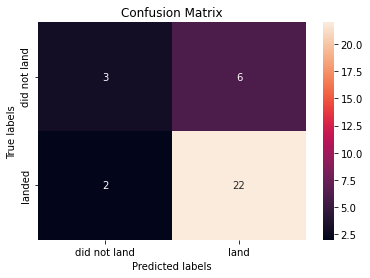

In [18]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

We see that logistic regression can distinguish between the different classes with a $76\%$ accuracy.  We have $6$ false positives and $2$ false negatives. 


### Support Vector Machine <a id='SVM'></a>

We start by creating a support vector machine object `svm` and then creating a <code>GridSearchCV</code> object  <code>svm_cv</code> with a 10-fold cross-validation as well. Lastly, we also fit this object to find the best parameters from a <code>parameters</code> dictionary.

In [19]:
parameters = {'kernel':('linear', 'rbf','poly', 'sigmoid'),
              'C': np.logspace(-3, 3, 7),
              'gamma':np.logspace(-3, 3, 7)}
svm = SVC()

These parameters allow the selection between four different kernel functions - `linear`, radial basis function(`rbf`), polynomial (`poly`) and `sigmoid` - and seven powers of base 10 both for $C$ and $\gamma$, ranging from $10^{-3}$ to $10^3$.

In [20]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [22]:
print("tuned hyperparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 1.0, 'gamma': 0.1, 'kernel': 'sigmoid'}
accuracy : 0.9098901098901099


Now we calculate the accuracy on the test data using the method <code>score</code>:

In [21]:
svm_cv.score(X_test, Y_test)

0.8484848484848485

Our support vector machine model has an $85\%$ accuracy. We can also plot the confusion matrix using our `plot_confusion_matrix` function.

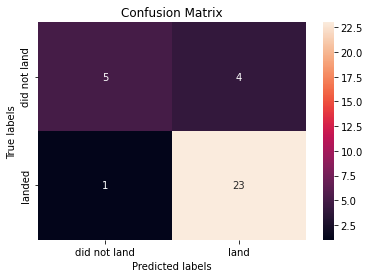

In [23]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Here we can see that our SVM model generated $4$ false positives and $1$ false negative.

### Decision Tree <a id='Decision_tree'></a>

We will use the same sequence of steps as used for the previous models. We are starting by creating a decision tree classifier object `tree` and then creating a <code>GridSearchCV</code> object <code>tree_cv</code> with a 10-fold cross-validation. We also create a `parameters` dictionary to include the range of hyperparameters to select from when performing the grid search.

In [24]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In our hyperparameter possibilities we have two criteria - Gini (`gini`) or `entropy` -, two different ways of choosing the features on which we split the nodes (`splitter`) - choosing the best attribute according to the criterion (`best`) or random predictor choice (`random`) -, two different maximum number of features to use for splitting (`max_features`)- Base 2 logarithm of the total number of features (`log2`) or the square root of the total number of features (`sqrt`) -, maximum tree depth (`max_depth`) of any even number from $2$ to $18$, three different minimum number of values per leaf (`min_samples_leaf`) and also three different minimum number of values in a leaf for it to be split (`min_samples_split`).

Now we fit the `GridSearchCV` object using the training data to select the best parameters from the above <code>parameters</code> dictionary.

In [25]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [26]:
print("tuned hyperparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.9098901098901099


Let's calculate the accuracy of the decision tree model on the test data using the method <code>score</code>:

In [27]:
tree_cv.score(X_test, Y_test)

0.7878787878787878

Our decision tree model has a $79\%$ accuracy. We can plot its confusion matrix using our `plot_confusion_matrix` function.

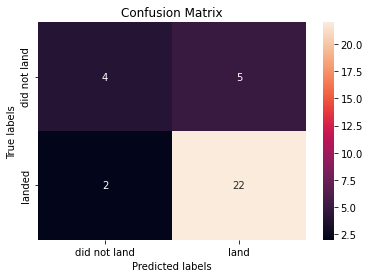

In [29]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

We can see that our decision tree model generated $5$ false positives and $2$ false negatives.

### K-Nearest Neighbours <a id='K-Nearest'></a>

Again, now for the k-nearest neighbours model we will use the same sequence of steps as used for the previous models. We will first create a k-nearest neighbors classifier `KNN` and define the range of hyperparameter values to select from, by using the a `parameters` dictionary once again.

Here, we will use a number of neighbours `n_neighbors` that can go from 1 up to 10, one of three algorithms - ball tree, KD tree and brute force. We will also use two different power parameters $p$ for the Minkowski distances between neighbours: if $p=1$, we are calculating Manhattan distances, whereas if $p=2$, then we are calculating the Euclidean distances.

In [30]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

then we will create a  <code>GridSearchCV</code> object <code>knn_cv</code>, again with a 10-fold cross validation - `cv = 10`.

Now let's perform the hyperparameter search to find the best parameters from the dictionary <code>parameters</code> and fit the training data.

In [31]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [32]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 1}
accuracy : 0.8565934065934065


Now let's calculate the accuracy of our k-nearest neighbours model on the test data using the method <code>score</code>:

In [33]:
knn_cv.score(X_test, Y_test)

0.8181818181818182

Our k-nearest neighbours model has an $81\%$ accuracy. We can plot its confusion matrix using our `plot_confusion_matrix` function.

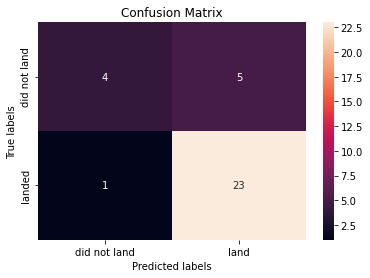

In [34]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

We can see that our k-nearest neighbours model generated $5$ false positives and $1$ false negative.

## Comparing the models <a id='Comparing_models'></a>

Finally, let's see which model performs best:

In [35]:
model_comparison = pd.DataFrame(columns=['Model','Accuracy'])
model_comparison['Model'] = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'K-Nearest Neighbours']
model_comparison['Accuracy'] = [logreg_cv.score(X_test, Y_test), svm_cv.score(X_test, Y_test), tree_cv.score(X_test, Y_test), knn_cv.score(X_test, Y_test)]
model_comparison

,Model,Accuracy
0,Logistic Regression,0.757576
1,Support Vector Machine,0.848485
2,Decision Tree,0.787879
3,K-Nearest Neighbours,0.818182


(0.0, 1.0)

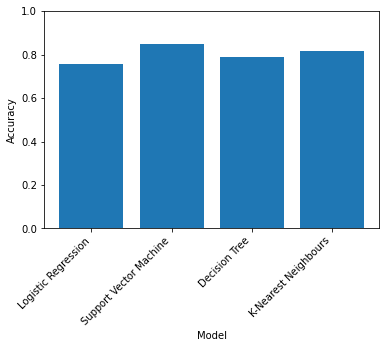

In [36]:
comparison_plot = plt.bar(model_comparison.Model, model_comparison.Accuracy)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)

It seems that the support vector machine model is the most accurate model in predicting landing success of Falcon 9.

## Acknowledgments

Lakshmi Holla

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">Joseph Santarcangelo</a>


This notebook was based on the [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone?specialization=ibm-data-science) course from the [IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science) specialization. However, all descriptions and code were widely extended from the model development performed during in the course.